# Generating images using Amazon Titan Image Generator

> ☝️ This notebook should work well with the **`Data Science 3.0`** kernel in Amazon SageMaker Studio and with the **`conda_python3`** in a Amazon SageMaker Notebook Instance.

---

In this tutorial, we will show how to use the new [Amazon Titan Image Generator](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-image-models.html) on [Amazon Bedrock](https://aws.amazon.com/bedrock/) model to generate (text-to-image) and edit (image-to-image) images.

![](images/titan_image_generator_playground.png)

## Image Prompting

Writing a good prompt can be somewhat of an art.

It is often difficult to predict whether a given prompt will yield a satisfactory result with a certain model. 

However, there are certain templates that have been known to work.

Broadly, a prompt can be broken down into three pieces:

1. **Type** of image (photograph/sketch/painting/&c.)
2. **Description** of the content (subject/object/environment/scene/&c.), and
3. **Style** of the image (realistic/artistic/&c.).

You can change each of the three parts individually to generate variations of an image. 

Adjectives have been known to play a significant role in the image generation process. 

Also, adding more details help in the generation process.

In order to generate a **realistic** image, you can use phrases such as

```
a photo of
a photograph of
realistic
hyper realistic
```

To generate something more **artistic**, you can use phrases like

```
by Pablo Picasso
oil painting by Rembrandt
landscape art by Frederic Edwin Church
pencil drawing by Albrecht Dürer
```

You can also combine different artists as well.

To generate artistic images by category, you can add the art category in the prompt such as

```
lion on a beach, abstract
```

Some other categories include

```
oil painting
pencil drawing
pop art
digital art
anime
cartoon
futurism
watercolor
manga
&c.
```

You can also include details such as lighting or camera lens such as

```
35mm wide lens
85mm wide lens
```

and details about the framing

```
portrait
landscape
close up
&c.
```

Note that models can generate different images even if same prompt is given multiple times. 

So, you can generate multiple images and select the image that suits your application best.

> ☝️ For more information on Amazon Titan Image Generator prompt engineering, see [Amazon Titan Image Generator Prompt Engineering Best Practices](https://d2eo22ngex1n9g.cloudfront.net/Documentation/User+Guides/Titan/Amazon+Titan+Image+Generator+Prompt+Engineering+Guidelines.pdf). 

## Setup

⚠️ ⚠️ ⚠️ Before running this notebook, make sure you've executed the [Bedrock boto3 setup notebook](../00_Intro/bedrock_boto3_setup.ipynb#Prerequisites). ⚠️ ⚠️ ⚠️


In [2]:
# Built-in libraries
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
from PIL import Image

# Utilities
module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."

# Initialize Bedrock client
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Use Cases

### Text to Image

In text-to-image mode, we provide a text description (prompt) of the image that **should** be generated.

What if we want to ***avoid*** specific content or stylistic choices? Because image generation models are typically trained from *image descriptions*, trying to directly specify what you **don't** want in the prompt (e.g. `man without a beard`) doesn't usually work well: it would be very unusual to describe an image by what it is not!

In the case of Amazon Titan Image Generator, we can specify a negative prompt to steer the model away from unwanted elements

In [3]:
prompt = "a beautiful lake surrounded by trees with a mountain range at the distance"
negative_prompts = "poorly rendered, poor background details, poorly drawn mountains, disfigured mountain features"

The Amazon Bedrock `InvokeModel` provides access to Amazon Titan Image Generator by setting the right model ID, and returns a JSON response including a [Base64 encoded string](https://en.wikipedia.org/wiki/Base64) that represents the (PNG) image.

When making an `InvokeModel` request, we need to fill the `body` field with a JSON object that varies depending on the task (`taskType`) you wish to perform viz. text to image, image variation, inpainting or outpainting. The Amazon Titan models supports the following parameters:
* `cfgscale` - determines how much the final image reflects the prompt
* `seed` - a number used to initialize the generation, using the same seed with the same prompt + settings combination will produce the same results
* `numberOfImages` - the number of times the image is sampled and produced
* `quality` - determines the output image quality (`standard` or `premium`)

> ☝️ For more information on available input parameters for the model, refer to the [Amazon Bedrock User Guide](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-image.html#model-parameters-titan-img-request-body) (Inference parameters > Amazon Titan image models > Model invocation request body fields).

The cell below invokes the Amazon Titan Image Generator model through Amazon Bedrock to create an initial image:

In [4]:
# Create payload
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,                    # Required
            "negativeText": negative_prompts   # Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # Range: 1 to 5 
            "quality": "standard",  # Options: standard or premium
            "height": 1024,        # Supported height list in the docs 
            "width": 1024,         # Supported width list in the docs
            "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
            "seed": 42             # Range: 0 to 214783647
        }
    }
)

# Make model request
response = boto3_bedrock.invoke_model(
    body=body,
    modelId="amazon.titan-image-generator-v1",
    accept="application/json", 
    contentType="application/json"
)

# Process the image
response_body = json.loads(response.get("body").read())
img1_b64 = response_body["images"][0]

# Debug
print(f"Output: {img1_b64[0:80]}...")

Output: iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAEAAElEQVR4nFT9TZIu27IjAElyj7xFD2N8...


By decoding our image string and loading it with an image processing library like [Pillow](https://pillow.readthedocs.io/en/stable/), we can display and manipulate the image

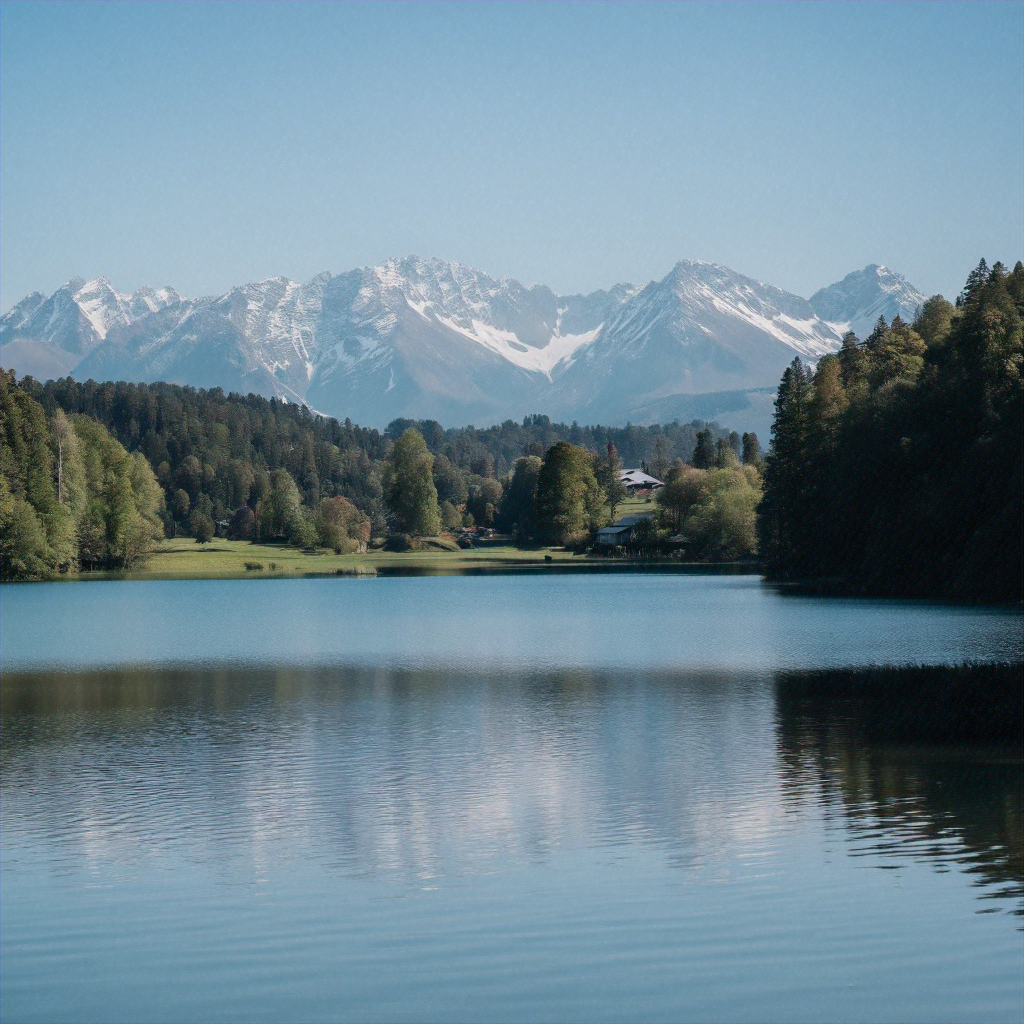

In [5]:
os.makedirs("data/titan", exist_ok=True)

# Decode + save
img1 = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(img1_b64, "utf-8")
        )
    )
)
img1.save(f"data/titan/image_1.png")

# Display
img1

### Image Variation

Generating images from text is powerful but, in some cases, you will need many rounds of prompt refinement to get just the right image.

Rather than starting from scratch, image-to-image generation lets us **modify** an existing image to make  specific changes.

We'll have to pass our initial image in base64 encoding to API, so let's get that out of the way.

(Feel free to use image created in the previous section or a different one)

In [6]:
def image_to_base64(img) -> str:
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

img1_b64 = image_to_base64(img1)
print(f"Input: {img1_b64[:80]}")

Input: iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAEAAElEQVR4nFT9TZIu27IjAElyj7xFD2N8


We will need a new prompt to guide the model when acting on the base image

In [7]:
change_prompt = "add a house on the lake shore"
negative_prompt = "bad quality, low resolution, cartoon"

The existing image is then passed through to the Titan model via the `images` parameter:

In [8]:
# Payload creation
body = json.dumps({
     "taskType": "IMAGE_VARIATION",
     "imageVariationParams": {
         "text": change_prompt,              # Optional
         "negativeText": negative_prompts,   # Optional
         "images": [img1_b64],               # One image is required
     },
     "imageGenerationConfig": {
         "numberOfImages": 1,
         "quality": "premium",
         "height": 1024,
         "width": 1024,
         "cfgScale": 10,
         "seed": 42
     }
 })

# Model invocation
response = boto3_bedrock.invoke_model(
    body=body,
    modelId="amazon.titan-image-generator-v1",
    accept="application/json", 
    contentType="application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
img2_b64 = response_body["images"][0]

# Debug
print(f"Output: {img2_b64[0:80]}...")

Output: iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAEAAElEQVR4nGT9TbomTa4jiAEgPbKqJxpo...


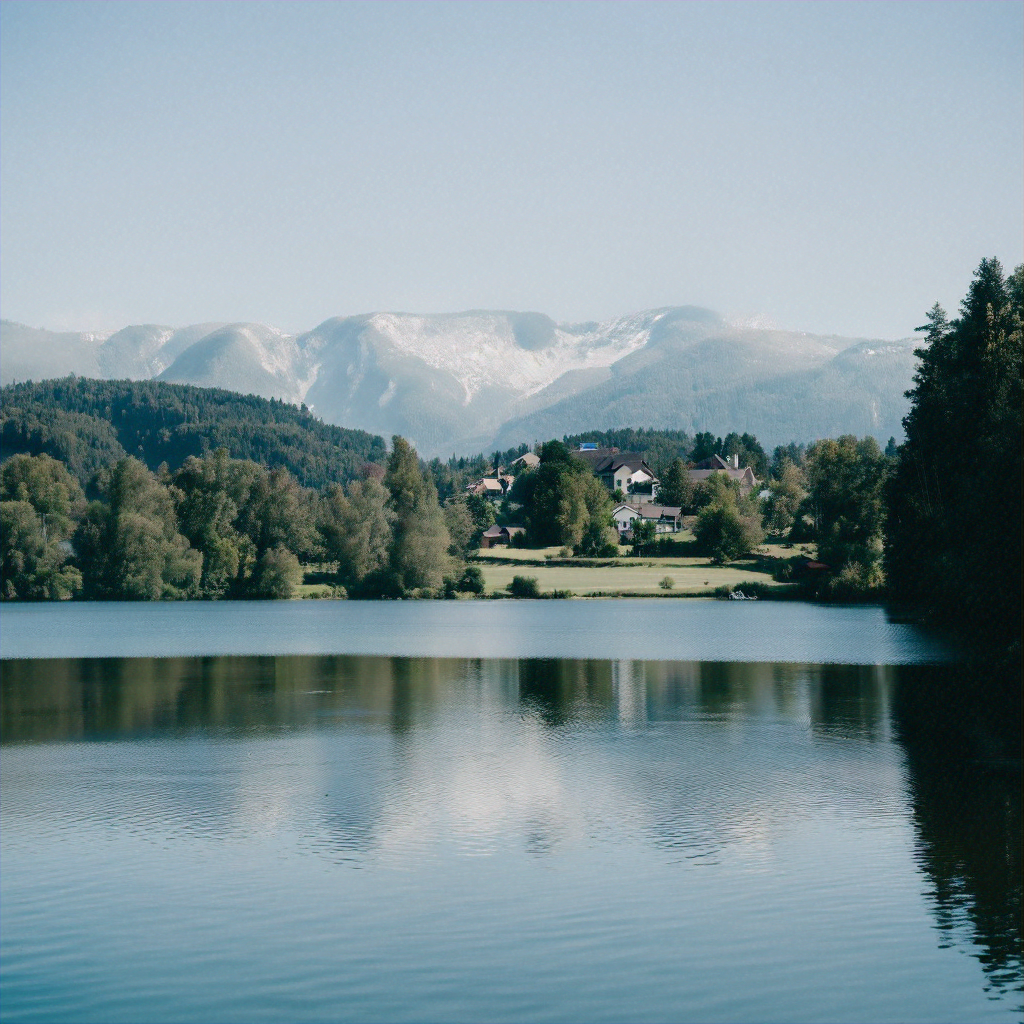

In [9]:
os.makedirs("data/titan", exist_ok=True)

# Decode + save
img2 = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(img2_b64, "utf-8")
        )
    )
)
img2.save("data/titan/image_2.png")

# Display
img2

### Inpainting

Another way to modify images is by using **inpainting**.

Inpainting refers to the process of replacing a portion of an image with another image based on a textual prompt.

By providing a mask image that outlines the portion to be replaced, a textual prompt, and the original image, the model can produce a new image that replaces the masked area with the object, subject, or environment described in the textual prompt.

Let's start by creating a function that generates a mask from the original image and a set of box coordinates `(top, left, right, bottom)`.

In [10]:
from PIL import ImageOps

def inpaint_mask(img, box):
    """Generates a segmentation mask for inpainting"""
    img_size = img.size
    assert len(box) == 4  # (left, top, right, bottom)
    assert box[0] < box[2]
    assert box[1] < box[3]
    return ImageOps.expand(
        Image.new(
            mode = "RGB",
            size = (
                box[2] - box[0],
                box[3] - box[1]
            ),
            color = 'black'
        ),
        border=(
            box[0],
            box[1],
            img_size[0] - box[2],
            img_size[1] - box[3]
        ),
        fill='white'
    )

We'll remove a single patch at the center of the image

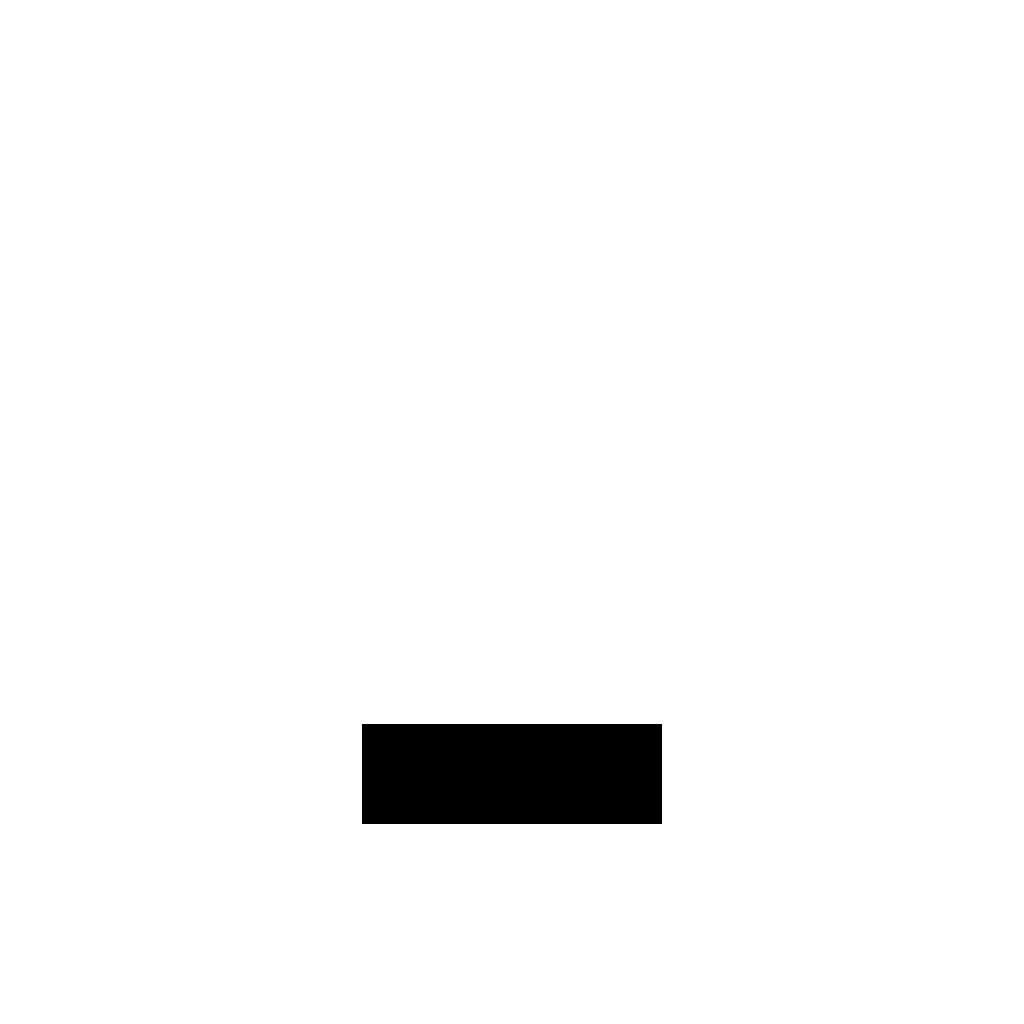

In [11]:
img2_size = img2.size
box = (
        (img2_size[0] - 300) // 2,
        img2_size[1] - 300,
        (img2_size[0] + 300) // 2,
        img2_size[1] - 200
    )

# Mask
mask = inpaint_mask(
    img2,
    box
)

# Debug
mask

We will now define what we want to change in the image.

In [12]:
inpaint_prompt = "add a fishing boat"
negative_prompts = "bad quality, low res"

Similarly to what we did before, we will the pass the previously generated image through to the Stable Diffusion model via the `image` parameter.

This time, we will also specify the `maskImage` parameter to pass the mask.

In [13]:
# Payload creation
body = json.dumps({
    "taskType": "INPAINTING",
    "inPaintingParams": {
        "text": inpaint_prompt,              # Optional
        "negativeText": negative_prompts,    # Optional
        "image": image_to_base64(img2),      # Required
        # "maskPrompt": "sky",               # One of "maskImage" or "maskPrompt" is required
        "maskImage": image_to_base64(mask),  # Input maskImage based on the values 0 (black) or 255 (white) only
    },                                                 
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "premium",
        "height": 1024,
        "width": 1024,
        "cfgScale": 7.5,
        "seed": 42
    }
})

# Model invocation
response = boto3_bedrock.invoke_model(
    body=body,
    modelId="amazon.titan-image-generator-v1",
    accept="application/json", 
    contentType="application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
img3_b64 = response_body["images"][0]
print(f"Output: {img3_b64[0:80]}...")

Output: iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAAEAAElEQVR4nGz9zY4tS/PmCf3sMXePlbta...


Lets show the image we just modified:

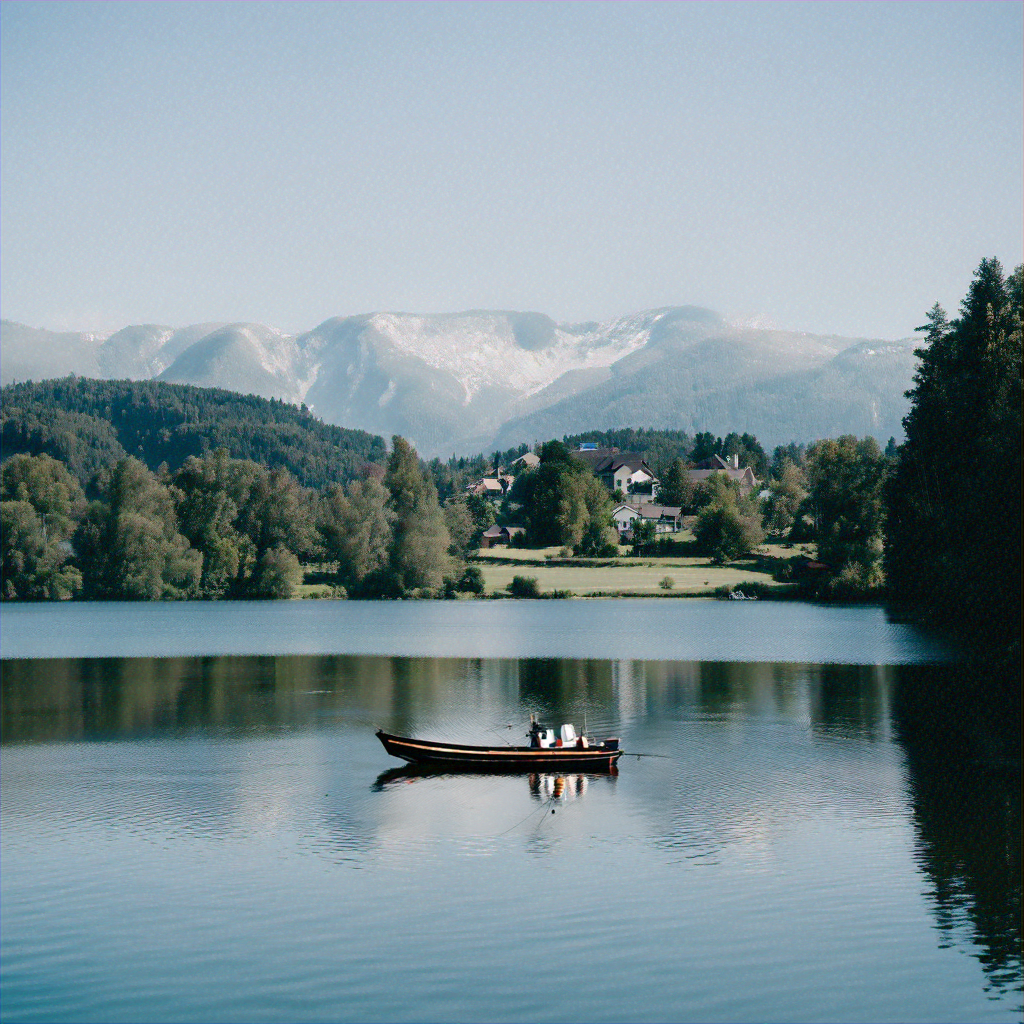

In [14]:
os.makedirs("data/titan", exist_ok=True)
inpaint = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(img3_b64, "utf-8")
        )
    )
)
inpaint.save("data/titan/inpaint.png")
inpaint

Apart from using "maskImage", we can use "maskPrompt".

In [ ]:
inpaint_prompt = "add a roller coaster"
negative_prompts = "bad quality, low res"
mask_prompt = "house" # replace house in img1 with a roller coaster

In [ ]:
# Payload creation
body = json.dumps({
    "taskType": "INPAINTING",
    "inPaintingParams": {
        "text": inpaint_prompt,              # Optional
        "negativeText": negative_prompts,    # Optional
        "image": image_to_base64(img1),     # Required
        "maskPrompt": mask_prompt,             # One of "maskImage" or "maskPrompt" is required
        # "maskImage": image_to_base64(mask),  # Input maskImage based on the values 0 (black) or 255 (white) only
    },                                                 
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "premium",
        "height": 1024,
        "width": 1024,
        "cfgScale": 7.5,
        "seed": 42
    }
})

# Model invocation
response = boto3_bedrock.invoke_model(
    body=body,
    modelId="amazon.titan-image-generator-v1",
    accept="application/json", 
    contentType="application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
img4_b64 = response_body["images"][0]
print(f"Output: {img4_b64[0:80]}...")

In [ ]:
os.makedirs("data/titan", exist_ok=True)
inpaint2 = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(img4_b64, "utf-8")
        )
    )
)
inpaint2.save("data/titan/inpaint2.png")
inpaint2

### Outpainting

In this final section, we are going to *extend* the image.

This process, known as **outpainting**, involves generating new pixels that *seamlessly* extend an image's existing boundaries.

We can do this by providing the original image and a segmentation mask, which can either be an image or a prompt.

Let's start by creating a function that takes in the original image and the target size `(width, height)` and returns a mask image.

In [ ]:
def outpaint_mask(img, new_size):
    """Generates a segmentation mask for outpainting"""
    # Image size must be a multiple of 64
    old_size = img.size
    assert len(new_size) == 2
    assert new_size[0] >= old_size[0]
    assert new_size[1] >= old_size[1]
    assert new_size[0] % 64 == 0
    assert new_size[1] % 64 == 0
    # Create a mask and expand it
    border = (
        (new_size[0] - old_size[0]) // 2,
        (new_size[1] - old_size[1]) // 2
    )
    return ImageOps.expand(
        Image.new(
            mode = "RGB",
            size = img.size,
            color = 'white'
        ),
        border=border,
        fill='black'
    )

We're going to crop the image created in the **Image Inpainting** section and then expand the cropped area

In [ ]:
inpaint_crop = ImageOps.crop(inpaint, border=(300, 400, 300, 200))
print(f"Crop size: {inpaint_crop.size}")
inpaint_crop

In [ ]:
# Define border
old_size = inpaint_crop.size
new_size = (1024, 1024)
border = (
    (new_size[0] - old_size[0]) // 2,
    (new_size[1] - old_size[1]) // 2
)

# Generate a mask
mask = outpaint_mask(inpaint_crop, new_size)

# Debug
print(f"Original Image: {old_size}")
print(f"Outpaint Mask: {mask.size}")
mask

Next, we define our prompts

In [ ]:
outpaint_prompt = "add some trees and houses near the lake"
# negative_prompt = "bad quality, low res"

We can add everything to our payload and make the request

In [ ]:
# Payload creation
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": outpaint_prompt,
            # "negativeText": negative_prompts,
            "image": image_to_base64(
                ImageOps.expand(
                    inpaint_crop,
                    border=border,
                    fill='white'
                )),
            #"maskPrompt": mask_prompt,
            "maskImage": image_to_base64(mask),
            "outPaintingMode": "DEFAULT"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "standard",
            "cfgScale": 1.5,
            "seed": 321,
        }
    }
)

# Model invocation
response = boto3_bedrock.invoke_model(
    body = body, 
    modelId = "amazon.titan-image-generator-v1",
    accept = "application/json", 
    contentType = "application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
image_5_b64_str = response_body["images"][0]
print(f"Output: {image_4_b64_str[0:80]}...")

Once it finishes, we can display the image

In [ ]:
os.makedirs("data", exist_ok=True)

# Decode + save
outpaint = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(image_5_b64_str, "utf-8")
        )
    )
)
outpaint.save("data/titan/outpaint.png")

# Display
outpaint

Apart from using "maskImage", we can use "maskPrompt".

In [ ]:
outpaint_prompt = "add some trees and houses near the lake"
# negative_prompt = "bad quality, low res"

# try different mask_prompt to see the difference in generated images
mask_prompt = "lake"
# mask_prompt = "forest"

In [ ]:
# Payload creation
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": outpaint_prompt,
            # "negativeText": negative_prompts,
            "image": image_to_base64(
                ImageOps.expand(
                    inpaint_crop,
                    border=border,
                    fill='white'
                )),
            # "image": image_to_base64(inpaint_crop),
            "maskPrompt": mask_prompt,
            # "maskImage": image_to_base64(mask),
            "outPaintingMode": "DEFAULT"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "standard",
            "cfgScale": 1.5,
            "seed": 321,
        }
    }
)

# Model invocation
response = boto3_bedrock.invoke_model(
    body = body, 
    modelId = "amazon.titan-image-generator-v1",
    accept = "application/json", 
    contentType = "application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
image_6_b64_str = response_body["images"][0]
print(f"Output: {image_6_b64_str[0:80]}...")

In [ ]:
os.makedirs("data", exist_ok=True)

# Decode + save
outpaint2 = Image.open(
    io.BytesIO(
        base64.decodebytes(
            bytes(image_6_b64_str, "utf-8")
        )
    )
)
outpaint2.save("data/titan/outpaint2.png")

# Display
outpaint2

## Summary

In this lab, we demonstrated how to generate new images from text and transform existing images with text instructions using [Amazon Titan Image Generator](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-image-models.html) on [Amazon Bedrock](https://aws.amazon.com/bedrock/).

Through the Bedrock API, we can provide a range of parameters to influence image generation (`text`, `negativeText`, `maskImage`, &c.)

One key point to note when using Amazon Bedrock is that the output image data is returned as a [Base64 encoded string](https://en.wikipedia.org/wiki/Base64) within the JSON API response. You can use the Python built-in [`base64` library](https://docs.python.org/3/library/base64.html) to decode this image data and then save a `.png` file. We also showed that image processing libraries like [Pillow](https://pillow.readthedocs.io/en/stable/) can be used to load (and edit) images within Python.

From here, you can explore more advanced image generation options or combine GenAI with traditional image processing tools to build the best creative workflow for your use case.